<p style="text-align: center">
    <img src="../../assets/images/untref-logo-negro.svg" />
</p>

<h3 style="text-align: center">Estructuras de Datos</h3>

<h2 style="text-align: center">Clase 10: Recuperación de la Información</h2>

## Recuperación de la Información

Recuperación de la Información o _Information Retrieval_ (IR) en inglés, se refiere a:

> Encontrar material (por ejemplo documentos) de naturaleza desestructurada (en general textos), con ciertas condiciones de búsqueda, dentro de una gran colección (en general almacenada en formato digital).

De **naturaleza desestructurada** significa que no está guardada de modo tal que sea fácil de reconocer su estructura (por ejemplo textos planos).

### Recuperación booleana

Dado el texto **"Cuentos desde el Reino Peligroso"** de Tolkien distribuido en PDF y `txt`, determinar en qué secciones aparecen las palabras **"Roverandom"** y **"hadas"** pero no **"Egidio"**.

Una posibilidad es buscar cada una de las palabras con un `find` en todas las secciones y luego calcular a mano cuáles cumplen con las tres condiciones (o con un programa equivalente: `grep`).

In [ ]:
!echo "'Roverandom' aparece en los cuentos:"
!grep -l -i "Roverandom" ./tolkien/*.txt
!echo "'hadas' aparece en los cuentos:"
!grep -l -i "hadas" ./tolkien/*.txt
!echo "'Egidio' aparece en los cuentos:"
!grep -l "Egidio" ./tolkien/*.txt

Pero si ahora me piden lo mismo para el total de la obra de Tolkien, o para una colección de documentos muy grande tenemos que hallar mejores maneras de recuperar información.

También nos pueden pedir información más sofisticada: por ejemplo, que esté la palabra **"hadas"** cerca de **"Roverandom"** (por ejemplo en la misma oración).

Para evitar hacer una búsqueda lineal de todo el texto cada vez que nos hacen una consulta, armamos un índice (matriz de incidencia) con todas las palabras que aparecen en cada documento (en nuestro caso cada sección de los textos de Tolkien).

|            | Introducción | Roverandom | Egidio el granjero | Tom Bombadil | El herrero de Wootton | Hoja de Niggle |
| ---------- | ------------ | ---------- | ------------------ | ------------ | --------------------- | -------------- |
| Roverandom | 1            | 1          | 0                  | 0            | 0                     | 0              |
| Egidio     | 1            | 0          | 1                  | 0            | 0                     | 0              |
| Bombadil   | 1            | 0          | 0                  | 1            | 0                     | 0              |
| Wootton    | 1            | 0          | 0                  | 0            | 1                     | 0              |
| Niggle     | 1            | 0          | 0                  | 0            | 0                     | 1              |
| hadas      | 1            | 1          | 0                  | 0            | 1                     | 0              |
| ...        | ...          | ...        | ...                | ...          | ...                   | ...            |

Para responder a la primera consulta tomamos las filas "Roverandom" y "hadas" y el complemento de "Egidio" y calculamos el AND de las tres:

```
110000 AND 110010 AND (NOT 101000) = 
110000 AND 110010 AND      010111  = 0100000
```

La respuesta entonces es: "Roverandom" es la única sección del texto donde están las palabras "Roverandom" y "hadas" pero no "Egidio".

Un índice así no puede construirse de manera ingenua como lo acabamos de hacer (va a estar lleno de ceros).

Vamos a representar de manera inteligente sólo la aparición de palabras en un texto (los `1`'s).

## Índice Invertido

Un **índice invertido** o **archivo invertido** es un diccionario donde las claves son las palabras y el contenido es una lista que contiene los documentos donde aparecen esas palabras

```Python
{
    "Roverandom": [
        "Introducción",
        "Roverandom",
    ],
    "Egidio": [
        "Introducción",
        "Egidio",
    ],
    # ...
}
```

El nombre es en realidad redundante: un índice siempre vuelve a trazar el mapa de los términos a las partes de un documento donde se producen.

La idea básica de un índice invertido se muestra en la figura.

<p style="text-align: center;">
    <img src="./figuras/indice_invertido_esquema.dio.svg" />
</p>

Mantenemos un diccionario de términos (a veces también llamado vocabulario o
léxico). Entonces para cada término, tenemos una lista de los documentos donde aparece el término. Esta lista de documentos se denomina _**postings**_.

En un índice invertido el diccionario, o vocabulario por lo general se mantiene en memoria, mientras que los _postings_ en disco

### Primera aproximación para construir un índice invertido:

1. Recolectar todos los documentos que se quieren indexar.
   > Definir documentos en nuestra aplicación. Puede ser capitulos de un libro, documentos individuales, etc.
   >
   >Dentro de una colección de documentos, asumimos que cada documento tiene un único número de serie, conocido como el identificador del documento (docID). Podemos simplemente asignar números enteros sucesivos a cada nuevo documento cuando se encuentra por primera vez.

2. Separar los documentos en palabras (tokens) de modo que cada documento sea una lista de tokens.
   > Unidad de información que queremos indexar

3. Hacer un preprocesamiento lingüístico.
   > Lematizar las palabras para indexar solo su raíz (por ejemplo perro, perritas, perrísimo, perrera, se puede almacenar en el índice como perr)
   >
   > Los verbos se indexan en infinitvo (por ejemplo corriamos, hayan corrido, corren, etc. se indexa como correr)
   >
   > Stop words. Lista de palabras que no se indexan por ejemplo preposiciones, artículos, conjunciones, pronombres, conjugaciones de los verbos ser y estar

4. Asociar los documentos a todos los tokens generados.
   > Hay distintos algoritmos para realizar esta asociación.

### Natural Language Toolkit (`nltk`)

In [ ]:
%pip install nltk

Luego abrir un intérprete de python, por ejemplo Idle y ejecutar

```python
>>> import nltk
>>> nltk.download()
```

<p style="text-align: center;">
    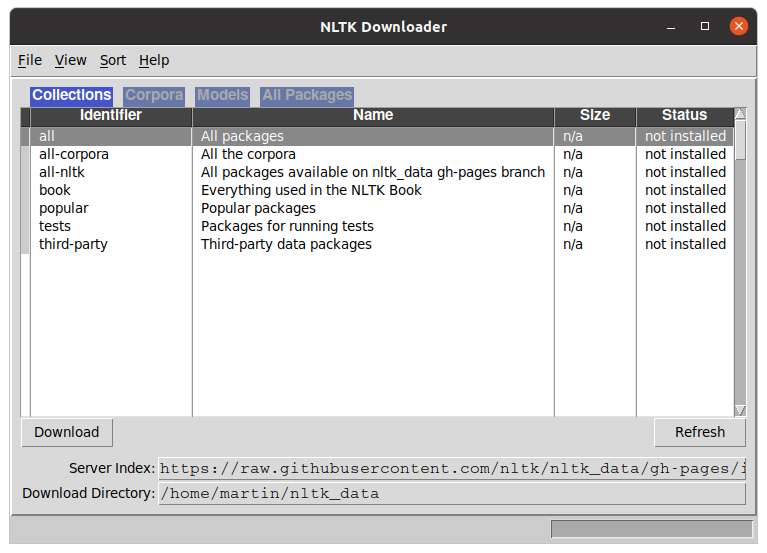
</p>

In [ ]:
from nltk.corpus import stopwords

stop_words = frozenset(stopwords.words("spanish"))

print(stop_words)

In [ ]:
from nltk.stem import SnowballStemmer  # Vamos a usar el lematizador de SnowballStemmer

spanish_stemmer = SnowballStemmer("spanish", ignore_stopwords=False)

palabras = ["casa", "casona", "caserío", "perritos", "perras", "corran", "corrida", "correr", "correremos"]
palabras_lematizadas = [spanish_stemmer.stem(w) for w in palabras]

for palabra, palabra_lematizada in zip(palabras, palabras_lematizadas):
    print("{0:>15} -> {1}".format(palabra, palabra_lematizada))

El _stemmer_ recorta las palabras, es una forma de lematización básica, que no tiene en cuenta el contexto. Aún con estas limitaciones es de gran utilidad para generar índices.

In [ ]:
from nltk.stem import SnowballStemmer  # Vamos a usar el lematizador de SnowballStemmer

spanish_stemmer = SnowballStemmer("spanish", ignore_stopwords=False)

palabras = ["pasto", "pasta", "cobra", "cobrar", "monto", "montar"]
palabras_lematizadas = [spanish_stemmer.stem(w) for w in palabras]

for palabra, palabra_lematizada in zip(palabras, palabras_lematizadas):
    print("{0:>15} -> {1}".format(palabra, palabra_lematizada))

### Algoritmo para construir un índice invertido por ordenamiento

1. La entrada para el algoritmo de indexación es una lista de tokens normalizados para cada documento (se puede pensar más abstractamente como una lista de pares `(token, nro_de_documento)`).

2. Se ordenan estos pares alfabéticamente por token y luego por nro de documento.

    - Cuando un token aparece más de una vez en el mismo documento, se ignoran las apariciones múltiples.

3. A cada token se le asocia la lista enlazada de los documentos en los que aparece.

    - Se puede asociar la frecuencia de un token (como dato adicional aunque no necesario para implementar una consulta booleana).

Para simplificar vamos a suponer que podemos cargar todos los documentos en un diccionario y vamos a mantener todo el índice en memoria.

Supongamos los siguientes documentos:

**Introduccion**:

> No sabemos cuándo empezó Tolkien a dirigir sus pensamientos al Reino Peligroso del País de las Hadas. 

**Roverandom**:

> Había una vez un perrito llamado Rover. Era muy pequeño y muy joven, pues de lo contrario se habría portado mejor; y era muy feliz jugando al sol en el jardín con una pelota amarilla, si nunca hubiera hecho lo que hizo. 

**Egidio**:

> Egidio el granjero tenía un perro. El nombre del perro era Garm. Los perros tenían que conformarse con nombres cortos en lengua vernácula; el latín culto quedaba reservado para sus dueños.

**Niggle**:

> Deberíamos salir al encuentro de centauros y dragones, y quizás así, de pronto, fijaríamos nuestra atención, como los pastores de antaño, en las ovejas, los perros, los caballos... y los lobos.\

In [ ]:
import string

from nltk.corpus import stopwords  # Stopwords
from nltk.stem import SnowballStemmer  # Stemmer


class IndiceInvertido:

    def __init__(self, documentos):
        """Recibe un diccionario con los documentos"""
        self.stop_words = frozenset(stopwords.words("spanish"))  # lista de stop words
        self._docs = documentos
        self._spanish_stemmer = SnowballStemmer("spanish", ignore_stopwords=False)
        self.__docs_to_docID()
        self.__generar_indice()

    def __docs_to_docID(self):
        """Asigna a cada documento un número y guarda dos diccionarios:
        el primero que tiene como clave el nombre del documento y como valor el
        numero de documento docID asociado y el segundo que permite realizar la
        operación inversa y tiene como clave los docID y como valor el nombre del
        documento"""
        self._doc_to_docID = {}
        docID = 0
        for doc in self._docs.keys():
            self._doc_to_docID[doc] = docID
            docID += 1
        self._docID_to_doc = dict((v, k) for k, v in self._doc_to_docID.items())

    def __lematizar_palabra(self, palabra):
        """Usa el stemmer para lematizar o recortar la palabra, previamente elimina todos
        los signos de puntuación que pueden aparecer. El stemmer utilizado también se
        encarga de eliminar acentos y pasar todo a minúscula, sino habría que hacerlo
        a mano"""

        palabra = palabra.strip(string.punctuation + "»" + "\x97" + "¿" + "¡")
        # "\x97" representa un guión

        palabra_lematizada = self._spanish_stemmer.stem(palabra)
        return palabra_lematizada

    def __generar_indice(self):
        """Genera los pares la lista de pares (palabra, docID)"""
        pares = []
        indice = {}
        for doc in self._docs:
            lista_palabras = [palabra for palabra in self._docs[doc].split() if not palabra in self.stop_words]
            lista_palabras = [self.__lematizar_palabra(palabra) for palabra in lista_palabras]

            pares = pares + [(palabra, self._doc_to_docID[doc]) for palabra in lista_palabras]
        # pares = sorted(pares, key = lambda tupla: tupla[0])
        for par in pares:
            posting = indice.setdefault(par[0], set())

            # if par[0] in indice:
            #    posting = indice[par[0]]
            # else:
            #    posting = set()
            #    indice[par[0]] = posting

            posting.add(par[1])

        self._indice = indice

    def buscar(self, palabra):
        salida = []
        palabra_lematizada = self.__lematizar_palabra(palabra)

        if palabra_lematizada in self._indice:
            for docID in self._indice[palabra_lematizada]:
                salida.append(self._docID_to_doc[docID])

        return set(salida)

In [ ]:
documentos = {
    "Introducción": "No sabemos cuándo empezó Tolkien a dirigir sus pensamientos al Reino Peligroso del País de las Hadas. Habían muchos perros en ese mundo para Roverandom. Egidio era un granjero y Niggle un soñador",
    "Roverandom": "Había una vez un perrito llamado Rover y su dueño Roverandom. El perro era muy pequeño y muy joven, pues de lo contrario se habría portado mejor; y era muy feliz jugando al sol en el jardín con una pelota amarilla, si nunca hubiera hecho lo que hizo. ",
    "Egidio": "Egidio el granjero tenía un perro. El nombre del perro era Garm. Los perros tenían que conformarse con nombres cortos en lengua vernácula; el latín culto quedaba reservado para sus dueños.",
    "Niggle": "Deberíamos salir al encuentro de centauros y dragones, y quizás así, de pronto, fijaríamos nuestra atención, como los pastores de antaño, en las ovejas, los perros, los caballos... y los lobos.",
}

ii = IndiceInvertido(documentos)

In [ ]:
ii._indice

In [ ]:
# Recuperación booleana
documentos = {"Introducción", "Roverandom", "Egidio", "Niggle"}

# perro and not Roverandom
ii.buscar("perro") & (documentos - ii.buscar("Roverandom"))

### Representación de índices

En nuestro ejemplo usamos un diccionario de Python para representar el índice invertido. Estos diccionarios están implementados sobre tablas de hash (Ver [documentación oficial](https://docs.python.org/es/3.8/faq/design.html#how-are-dictionaries-implemented-in-cpython))

Como sabemos, con tablas de hash la operación de búsqueda está muy optimizada, y se puede encontrar todos los documentos (docIDs) en los que aparece una palabra en tiempo constante.

La implementación sobre tablas de hash también tiene algunas limitaciones, por ejemplo, no es posible mantener el orden de las palabras, lo que nos permitiría realizar búsquedas con comodines, por ejemplo si queremos buscar todas las palabras que empiezan con **abra\***

Con árboles se resuelven los problema de prefijos (todas las palabras que empiezan con "abra").
Si el árbol está balanceado la búsqueda es del orden de O(log(M)) donde M es la cantidad de palabras

¿Qué pasa si permitimos una mayor cantidad de ramificaciones?

Balanceo + mayor cantidad de ramas => Árbol B.

## Bibliografía

Information Retrieval:

> [An Introduction to Information Retrieval, online edition, Cambridge UP by Christopher D. Manning, Prabhakar Raghavan and Hinrich Schütze](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf)
>
> Capítulos 1, 2 y 3